![](imgs/training.png)

In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks import *
import rpsalweaklydet as rps

In [2]:
bs = 4
img_sz  = 512
crop_sz = 64
data_path = '/home/renato/data/chestxray8/'

In [3]:
# Sample small subset of the data
def sample_data(df): return pd.concat([o.sample(40) for _,o in df.groupby('is_valid')])
data = rps.data.get_chestxray8(data_path, bs, img_sz, processor=sample_data, valid_only_bbx=True)

# Loading trained model

In [4]:
model = rps.models.get_detection_model(models.densenet121, crop_arch=models.resnet34, c=14, img_sz=img_sz).cuda()
model.load_state_dict(torch.load('../models/fullmodel_densenet121.pth'))

<All keys matched successfully>

In [5]:
# Obtain a batch of samples with bounding boxes
xb,yb = rps.data.get_bbx_samples(data.valid_dl, n_samples=8)

In [6]:
# Images, boxes      , labels
xb.shape, yb[0].shape, yb[1].shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 4, 4]), torch.Size([8, 4]))

## Get results

In [7]:
with torch.no_grad(),\
     rps.hooks.multi_hook_output(model.apply_deltas) as anchors_hook,\
     rps.hooks.multi_hook_output(model.head.scores_layer) as scores_hook:
    yb_ = model.eval()(xb.cuda())

/home/renato/anaconda3/envs/ml/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [8]:
# preds -> [bs,2,n_classes]
#              0 -> crop logit
#              1 -> full image logit
yb_[1].shape

torch.Size([8, 2, 14])

In [9]:
# Full image prediction
pred = yb_[1][:,1].sigmoid()
pred.shape

torch.Size([8, 14])

In [10]:
out_saliency = model.saliency_hook.stored
anchors = anchors_hook.stored
scores = scores_hook.stored

out_saliency.shape

torch.Size([8, 14, 128, 128])

In [11]:
# Pass elements to cpu
yb_,out_saliency,anchors,scores = [to_cpu(o) for o in [yb_,out_saliency,anchors,scores]]

In [12]:
# Classes on the dataset
len(anchors),len(scores)

(14, 14)

In [13]:
# Batch size
len(anchors[0]),len(scores[0])

(8, 8)

In [14]:
# Anchors per sample -> [x1,y1,x2,y2]
anchors[0][0].shape

torch.Size([395, 1, 4])

In [15]:
# Score the model assigned to each anchor
scores[0][0].shape

torch.Size([395, 1])

## Show

In [16]:
# To help the visualizations we need this import
from rpsalweaklydet.structures import *

In [51]:
idx = np.random.choice(xb.size(0)) # Choose a random sample
idx

6

In [52]:
# Get the input image and label
x = data.x.reconstruct(data.denorm(xb[idx].cpu()))
y = data.y.reconstruct((yb[0][idx].cpu(),yb[1][idx].cpu()), x=x)

ylbl = '\n'.join([data.classes[o] for o in y.data[1]])
ylbl

'Atelectasis\nEffusion'

In [53]:
# Not all the labels are annotated with bounding box
y.data[0]

tensor([[-1.0000, -1.0000,  1.0000,  1.0000],
        [ 0.3095,  0.1656,  0.5140,  0.8144]])

In [54]:
# Lets find which label have bounding box annotated
with_boxes = torch.where((y.data[0] == rps.data.empty_box()).sum(1) != 4)[0]
with_boxes = listify(y.data[1][with_boxes])
with_boxes

[5]

### Get heatmaps

In [55]:
# Heatmaps (from saliency maps)
saliency_hms = HeatmapsLbl.from_tensor(out_saliency.sigmoid(), classes=data.classes[1:])
saliency_hm = saliency_hms[idx]
saliency_hm # Each element contains 1 heatmap for each label on our dataset

HeatmapLbl(Heatmap([128, 128]), Heatmap([128, 128]), Heatmap([128, 128]), Heatmap([128, 128]), Heatmap([128, 128]), ...) [14 elements]
14 classes (['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [56]:
# Heatmaps (from detection module)
detection_hm = HeatmapLbl([Heatmap.from_preds(anchor[idx], score[idx], img_sz)
                           for anchor,score in zip(anchors,scores)], classes=data.classes[1:])
detection_hm # Each element contains 1 heatmap for each label on our dataset

HeatmapLbl(Heatmap([512, 512]), Heatmap([512, 512]), Heatmap([512, 512]), Heatmap([512, 512]), Heatmap([512, 512]), ...) [14 elements]
14 classes (['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [57]:
# `saliency_hm` is smaller as its extracted from the last convolution before pooling.
# We resize it to be able to merge both heatmaps.
saliency_hm.resize(img_sz)
saliency_hm.to_tensor().shape, detection_hm.to_tensor().shape

(torch.Size([14, 512, 512]), torch.Size([14, 512, 512]))

In [58]:
# Heatmaps (from merging saliency and detection heatmaps)
mix_hm = HeatmapLbl.from_tensor(saliency_hm.to_tensor() * detection_hm.to_tensor(), classes=data.classes[1:])
mix_hm

HeatmapLbl(Heatmap([512, 512]), Heatmap([512, 512]), Heatmap([512, 512]), Heatmap([512, 512]), Heatmap([512, 512]), ...) [14 elements]
14 classes (['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [59]:
# Pick one label to show
lbl_idx = with_boxes[0]
lbl = data.classes[lbl_idx]
lbl

'Effusion'

In [60]:
# Label prediction
pred_lbl = pred[idx,lbl_idx-1].item()
pred_lbl

0.9517567753791809

Prediction (Effusion): 0.9518


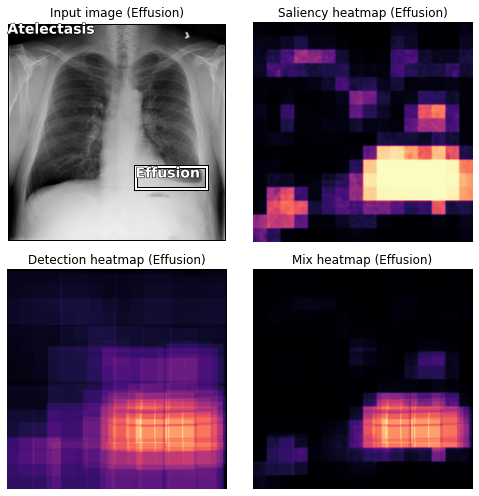

In [61]:
# Show
fig,axs = plt.subplots(2, 2, figsize=(7,7))
axs = axs.flatten()
x.show(y=y, ax=axs[0], title=f'Input image ({lbl})')
saliency_hm.get_class(lbl).show(ax=axs[1], title=f'Saliency heatmap ({lbl})')
detection_hm.get_class(lbl).show(ax=axs[2], title=f'Detection heatmap ({lbl})')
mix_hm.get_class(lbl).show(ax=axs[3], title=f'Mix heatmap ({lbl})')
print(f'Prediction ({lbl}): {pred_lbl:.4f}')
plt.tight_layout()

### Get bounding boxes

In [62]:
# Boxes from labels
true_bb = BoundingBoxLbl.from_preds(y.data, sz=img_sz, classes=data.classes)
true_bb

BoundingBoxLbl(BoundingBox((298.38, 335.24, 464.50, 387.57), area=8694.12, sz=[512, 512])) [1 elements]
classes (['Effusion'])

In [63]:
# Single box for the label to show
true_bb_lbl = true_bb.get_class(lbl)
true_bb_lbl

BoundingBox((298.38, 335.24, 464.50, 387.57), area=8694.12, sz=[512, 512])

In [64]:
# Boxes from predictions
th = 0.9
saliency_bb = saliency_hm.get_most_active_contours(th)
detection_bb = detection_hm.get_most_active_contours(th)
mix_bb = mix_hm.get_most_active_contours(th)

# Get boxes from the selected label
predicted_boxes = [o.get_class(lbl) for o in (saliency_bb, detection_bb, mix_bb)]
predicted_boxes

[BoundingBox((257.00, 289.00, 505.00, 415.00), area=31248.00, sz=[512, 512]),
 BoundingBox((235.00, 302.00, 490.00, 454.00), area=38760.00, sz=[512, 512]),
 BoundingBox((255.00, 289.00, 501.00, 424.00), area=33210.00, sz=[512, 512])]

Prediction (Effusion): 0.9518


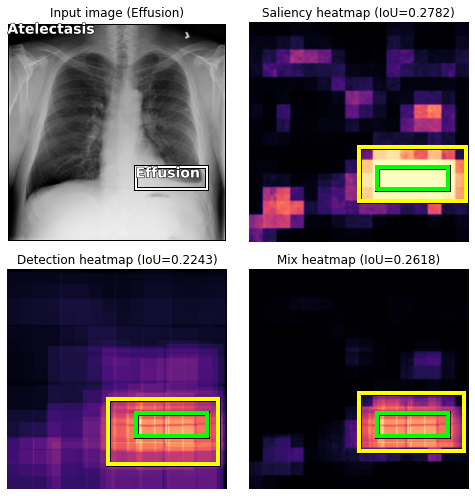

In [65]:
# Show
fig,axs = plt.subplots(2, 2, figsize=(7,7))
axs = axs.flatten()
x.show(y=y, ax=axs[0], title=f'Input image ({lbl})')
saliency_hm.get_class(lbl).show(ax=axs[1])
detection_hm.get_class(lbl).show(ax=axs[2])
mix_hm.get_class(lbl).show(ax=axs[3])
print(f'Prediction ({lbl}): {pred_lbl:.4f}')

# Draw boxes
for ax,box,title in zip(axs[1:],predicted_boxes,['Saliency','Detection','Mix']):
    true_bb_lbl.draw(ax, 'lime', lw=4)
    box.draw(ax, 'yellow', lw=4)
    iou = true_bb_lbl.iou(box)
    ax.set_title(f'{title} heatmap (IoU={iou:.4f})')

plt.tight_layout()

## See all labels

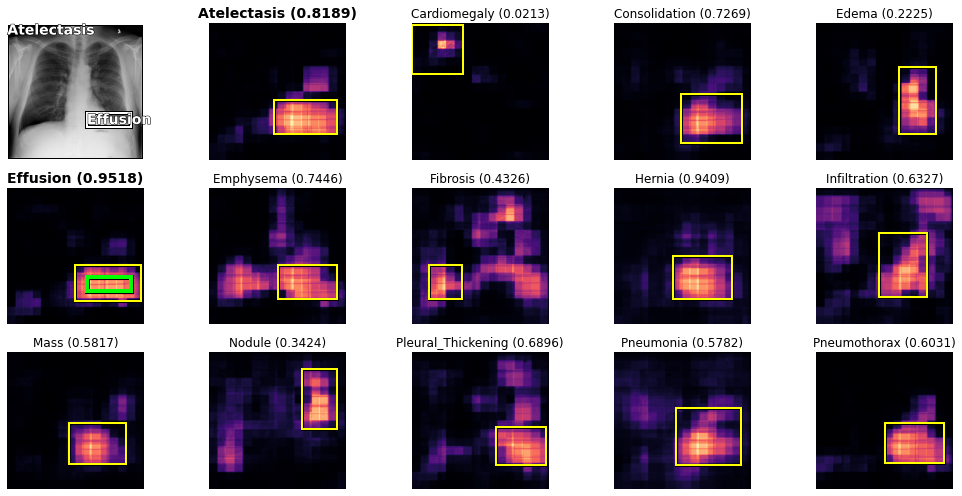

In [107]:
fig,axs = plt.subplots(3, 5, figsize=(14,7))
axs = axs.flatten()
x.show(y=y, figsize=(4,4), ax=axs[0])
mix_hm.show(axs=axs[1:])
for ax,box,c,t in zip(axs[1:],mix_bb,data.classes[1:],pred[idx]):
    box.draw(ax, 'yellow')
    islbl = c in ylbl
    ax.set_title(f'{c} ({t:.4f})', size=14 if islbl else 12, fontweight='bold' if islbl else 'normal')
    if islbl:
        b = true_bb.get_class(c)
        if b is not None: b.draw(ax, lw=4, color='lime', resize=img_sz)
    
plt.tight_layout()

# Sample on how to train the model

## Using fastai

In [6]:
learn = rps.models.get_detection_learner(data, models.densenet121, crop_arch=models.resnet34)

In [8]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,auc_Atelectasis,auc_Cardiomegaly,auc_Consolidation,auc_Edema,auc_Effusion,auc_Emphysema,auc_Fibrosis,auc_Hernia,auc_Infiltration,auc_Mass,auc_Nodule,auc_Pleural_Thickening,auc_Pneumonia,auc_Pneumothorax,mean_auroc,bce_crop,bce_full,time
0,0.122211,0.221369,0.500000,0.351254,0.348571,0.974359,0.498576,0.435897,0.076923,0.282051,0.637333,0.382857,0.496667,0.657658,0.380952,0.554688,0.469842,0.115742,0.105627,00:06


## Plain pytorch

In [4]:
model = rps.models.get_detection_model(models.densenet121, crop_arch=models.resnet34, c=14, img_sz=img_sz).cuda()

In [5]:
pos_weights,neg_weights = rps.models.get_class_weights(data)
loss_func = rps.models.SaliencyDetMultiBCE(pos_weights, neg_weights).cuda()

In [7]:
opt = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# Example for one epoch
train_losses = []
valid_losses = []

model.train()
for xb,yb in progress_bar(data.train_dl):
    yb_ = model(xb)
    loss = loss_func(yb_, *yb)
    train_losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()
    
model.eval()
with torch.no_grad():
    for xb,yb in progress_bar(data.valid_dl):
        yb_ = model(xb)
        loss = loss_func(yb_, *yb)
        valid_losses.append(loss.item())

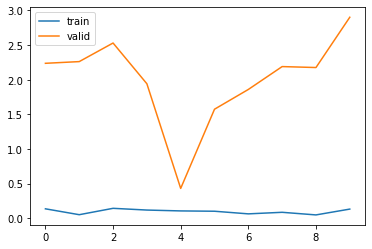

In [10]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend();